**How to.** Вписываем свою задачу следующим образом: 
1. Создаём блок из трёх ячеек: описание задачи, реализация, демонстрация. 
1. В описании задачи пишем: `# Название задачи, ФИО`, после делаете краткое описание реализации с описанием входов и выходов.
1. Локально реализуете свои ф-ии и тестируете. После вставляете в общий ноутбук. Требуется проверять не только работоспособность своей ф-ии, но и взаимодействия с другими. 

# Восстановление модели по графу вычисления, Яковлев Константин 

Добавление следующих возможностей:

1. Построение графа вычислений
2. Вычисление прогноза на произвольном объекте
3. Оптимизация параметров модели



In [1]:
from typing import List, Tuple, Any
import typing
import numpy as np
import torch

from time import sleep
from tqdm import tqdm


_PRIMITIVES = {
    'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
    'gauss': lambda x: np.exp(-x ** 2),
    'exp': lambda x: np.exp(x),
    'linear': lambda x, a, b: a * x + b,
    'quad': lambda x: x ** 2,
    '+': lambda x, y: x + y,
    '*': lambda x, y: x * y,
    '/': lambda x, y: x / y,
}


class Node(torch.nn.Module):
    pass

class Node(torch.nn.Module):
    def __init__(self, childs: List[Node], op_name: str, params=List[float]):
        """
        pararm: childs: List of childs
        param: op_name: operation name
        param: params: parameters of the operation
        """
        super(Node, self).__init__()
        self.op_name = op_name
        self.childs = childs
        self.params = params
        
    def forward(self, args: List[torch.tensor]):
        if len(self.childs) == 0: # if it is a leaf
            return _PRIMITIVES[self.op_name](*args, *self.params)
        else:
            return _PRIMITIVES[self.op_name](*[c(args) for c in self.childs], *self.params)

    
class Model(torch.nn.Module):
    def __init__(self, node: Node):
        super(Model, self).__init__()
        self.head = node
    
    
    def forward(self, x: torch.tensor):
        return self.head([x])
    
    def fit(self, X_train: np.array, y_train: np.array, verbose=False):
        def to_pytorch(node: Node):
            node.params = torch.nn.Parameter(torch.tensor(node.params).float())
            for c in node.childs:
                to_pytorch(c)
                
        def to_numpy(node: Node):
            old_params = node.params.clone()
            del node.params
            node.params = old_params.detach().numpy()
            for c in node.childs:
                to_numpy(c)
                
        assert X_train.shape[0] == y_train.shape[0]
        to_pytorch(self.head)
        X_train = torch.tensor(X_train)
        y_train = torch.tensor(y_train)
        
        optimizer = torch.optim.SGD(self.parameters(), lr=3e-4)
        criterion = torch.nn.MSELoss()
        it = range(50)
        if verbose:
            it = tqdm(it)
        for step in it:
            for i in range(X_train.shape[0]):
                optimizer.zero_grad()
                sleep(0.01)
                loss = criterion(model(X_train[i]), y_train[i])
                loss.backward()
                if verbose:
                    it.set_postfix({'loss' : loss.item()})
                optimizer.step()
        
        #to_numpy(self.head)
        
    
    
    
# Examples
tree = Node([], 'gauss', [])
print(tree([np.array([5, 6])]))

tree = Node([], '+', [])
print(tree([np.array([2, 3]), np.array([3, 2])]))

tree = Node([Node([], 'gauss', []), Node([], 'gauss', [])], '/', [])
print(tree([np.array([5, 4])]))

tree = Node([], 'linear', [1, 2])
print(tree([np.array([2, 3])]))

model = Model(tree)
print(model(np.array([1, 2])))

model.fit(np.random.rand(3, 2), np.random.rand(3), verbose=True)



[1.38879439e-11 2.31952283e-16]
[5 5]
[1. 1.]
[4 5]
[3 4]


  0%|          | 0/50 [00:00<?, ?it/s]/home/viacheslav/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 50/50 [00:03<00:00, 12.62it/s, loss=6.24]


# Визуализация дерева, Щагин

In [2]:
import graphviz

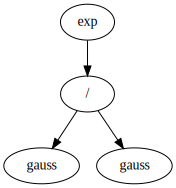

In [4]:
def draw_tree(graph, tree, parent_id = '0'):
  graph.node(parent_id, tree.op_name)
  for id, child in enumerate(tree.childs):
    child_id = str(parent_id) + str(id)
    graph.node(child_id, child.op_name)
    graph.edge(str(parent_id), child_id)
    draw_tree(graph, child, parent_id=child_id)

tree = Node([Node([Node([], 'gauss', []), Node([], 'gauss', [])], '/', [])], 'exp', [])
tree_graph = graphviz.Digraph('tree-graph', comment='Tree graph')
draw_tree(tree_graph, tree)
tree_graph

# Упрощение дерева, Сафиуллин
На вход принимается дерево и возвращается его упрощенное представление в виде функции

In [5]:
import inspect
import sympy

_PRIMITIVES["itself"] = lambda x: x

primitives_to_child_count = {
    'sigmoid': 1, 'gauss': 1, 'exp': 1, 'linear': 1, 'quad': 1, 'itself': 1,
    '+': 2, '*': 2, '/': 2
}

def to_str(tree):
    if primitives_to_child_count[tree.op_name] == 1:
        if len(tree.childs):
            if tree.op_name == "itself":
                return to_str(tree.childs[0])
            return f"{tree.op_name}({to_str(tree.childs[0])})"
        if tree.op_name == "itself":
            return "x"   
        return f"{tree.op_name}(x)"
    else:
        return f"{to_str(tree.childs[0])}{tree.op_name}{to_str(tree.childs[1])}"



def simplify_tree(tree):
    s = to_str(tree)
    end  =  '(x)'
    answer = ''
    for string in s.split(end):
        while string:
          if (string[0]=='x' )or (string[0] in ['+','*','/']):
            answer = answer + string[0]
            string = string[1:]
            
            if string and ((string[0] in ['+','*','/']) or (string[0]=='x' )):
                answer = answer + string[0]
                string = string[1:]
          if string in _PRIMITIVES.keys():
              temp =  str(inspect.getsource(_PRIMITIVES[string]))
              start = temp.index('lambda x')
              end = temp.index(': ',start+1)

              start = temp[start:end+2]
              end_temp = ','
              answer = answer + '('+((temp.split(start))[1].split(end_temp)[0])+ ')'
              string = ''
    expr = (sympy.simplify(answer.replace('np.','')))

    return expr

def lambda_complex(tree):
    if ('a' and 'b') in str(simplify_tree(tree)):
        return sympy.lambdify(['x','a','b'], simplify_tree(tree), modules=['numpy'])
    else:
        return sympy.lambdify('x', simplify_tree(tree), modules=['numpy'])

In [6]:
tree1 = Node([Node([], 'linear', [1, 2]), Node([], 'quad', [])], '*', [])
tree2 = Node([Node([Node([], 'gauss', []), Node([], 'exp', [])],'+',  []), Node([], 'exp', [])], '*', [])

print(f"Simplified function of {to_str(tree1)}: ",simplify_tree(tree1))

print(f"Simplified function of {to_str(tree2)}: ",simplify_tree(tree2))


func_lambda = lambda_complex(tree1)
print('Combination with linear: ',func_lambda(5,5,5))
func_lambda = lambda_complex(tree2)
print('Combination: ',func_lambda(5))

Simplified function of linear(x)*quad(x):  x**2*(a*x + b)
Simplified function of gauss(x)+exp(x)*exp(x):  exp(2*x) + exp(-x**2)
Combination with linear:  750
Combination:  22026.465794806732


# Генерация датасетов, Пилькевич

* На вход принимается массив с числом семлов `class_nums` для генерации каждого класса, и общие границы генерации данных `loc, scale`. 
* На выходе два массива из `X, Y` с данными для каждой ф-ии.

In [7]:
import scipy.stats as sps

import matplotlib.pyplot as plt 


_CLASSES = [
    Node([Node([], 'linear', [5, 0])], 'sigmoid', []), 
    Node([Node([], 'linear', [3, -4])], 'gauss', []), 
    Node([], 'exp', []), 
    Node([], 'linear', [2, 1]), 
    Node([], 'quad', []),     
    Node(
        [
            Node([], 'quad', []),
            Node([], 'linear', [5, 10]) 
        ], 
        '+', 
        []
    ),     
    Node(
        [
            Node([Node([], 'linear', [3, -4])], 'gauss', []),
            Node([ Node([Node([], 'linear', [3, 4])], 'gauss', [])], 'linear', [-1, 0]) 
        ], 
        '+', 
        []
    ), 
]


def generate_data(class_nums: List[int], loc: float = 0, scale: float = 1) -> typing.Tuple[float, Any]:
    assert len(class_nums) == len(_CLASSES)
    X = [sps.uniform(loc=loc, scale=scale).rvs(num) for num in class_nums]
    noises = [sps.norm(scale=1e-2).rvs(num) for num in class_nums] 
    Y = [f([x]) + noise for f, x, noise in zip(_CLASSES, X, noises)]
    return X, Y

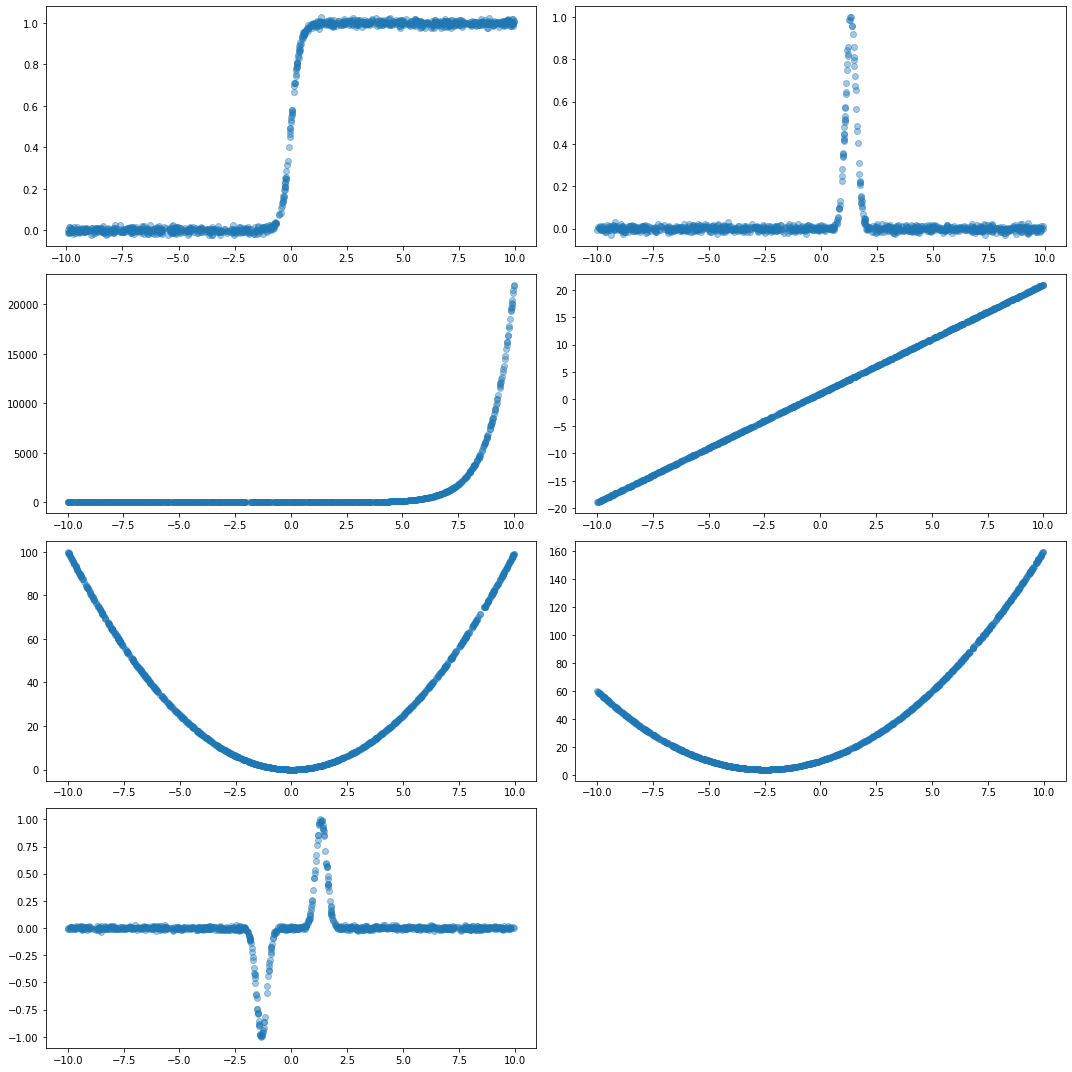

In [8]:
X, Y = generate_data([1000]*7, -10, 20)

plt.figure(figsize=(15, 15))

for i, (x, y) in enumerate(zip(X, Y)): 
    plt.subplot((len(X) + 1) // 2, 2, i+1)
    plt.scatter(x, y, alpha=0.4)
    
plt.tight_layout()

# Генетика, порождение моделей, Панкратов
Использовать последнюю функцию, вход -- список с начальными моделями, выход - список порожденных. Перед этим изменить константу NUM_GENETIC - число итераций функции

In [9]:
from scipy.stats import bernoulli
from inspect import signature
NUM_GENETIC = 10
def change_primitive(Tree):
  available_primitives = []
  tree_sign = len(signature(_PRIMITIVES[Tree.op_name]).parameters)
  for func in _PRIMITIVES: 
    if(len(signature(_PRIMITIVES[func]).parameters) == tree_sign):
       available_primitives.append(func)
  p = np.random.uniform()
  Tree.op_name = available_primitives[int(p//(1/(len(available_primitives))))]
  return(Tree)
                                           
def choose_random_node(Tree):
  p = np.random.uniform()
  if(p < 1/(1 + len(Tree.childs))):
    return Tree
  else:
    return choose_random_node(Tree.childs[int(p//(1/(1 + len(Tree.childs)))) - 1])

def change_single_node(Tree):
  p = np.random.uniform()
  if(p < 1/(1 + len(Tree.childs))):
    Tree = change_primitive(Tree)
    return Tree
  else:
    return change_single_node(Tree.childs[int(p//(1/(1 + len(Tree.childs)))) - 1]) 

def change_pair_of_nodes(Tree1,Tree2):
  p = np.random.uniform()
  q = np.random.uniform()
  if(p < 1/(1 + len(Tree1.childs))) and (q < 1/(1 + len(Tree2.childs))):
    Tree1,Tree2 = Tree2,Tree1
  if(p >= 1/(1 + len(Tree1.childs))) and (q >= 1/(1 + len(Tree2.childs))):
    Tree1.childs[int(p//(1/(1 + len(Tree1.childs)))) - 1], Tree2.childs[int(q//(1/(1 + len(Tree2.childs)))) - 1] = change_pair_of_nodes(Tree1.childs[int(p//(1/(1 + len(Tree1.childs)))) - 1],Tree2.childs[int(q//(1/(1 + len(Tree2.childs)))) - 1])
  if(p < 1/(1 + len(Tree1.childs))) and (q >= 1/(1 + len(Tree2.childs))):
    Tree1,Tree2.childs[int(q//(1/(1 + len(Tree2.childs)))) - 1] = change_pair_of_nodes(Tree1,Tree2.childs[int(q//(1/(1 + len(Tree2.childs)))) - 1])
  if(p >= 1/(1 + len(Tree1.childs))) and (q < 1/(1 + len(Tree2.childs))):
    Tree1.childs[int(p//(1/(1 + len(Tree1.childs)))) - 1], Tree2 = change_pair_of_nodes(Tree1.childs[int(p//(1/(1 + len(Tree1.childs)))) - 1],Tree2)
  return(Tree1,Tree2)

def modify_trees(*trees):
    trees = list(trees)
    for i in range(NUM_GENETIC):
        a = np.random.randint(0,len(trees))
        b = np.random.randint(0,len(trees))
        newtree1,newtree2 = change_pair_of_nodes(trees[a],trees[b])
        newtree1 = change_single_node(newtree1)
        trees.append(newtree1)
        trees.append(newtree2)
        trees.append(Node([trees[a],trees[b]], '+', []))
    return trees  

In [10]:
tree1 = Node([Node([], 'gauss', []), Node([], 'sigmoid', [])], '/', [])
tree2 = Node([Node([Node([], '+', [])], 'exp', []), Node([], 'exp', [])], '*', [])
tree3,tree4 = change_pair_of_nodes(tree1,tree2)
trees = [tree1,tree2,tree3,tree4]
trees =  modify_trees(*trees)

# Генетика (selection), Горпинич Мария

In [11]:
class Selection:

    def __init__(self, population, eval_crit, eval_crit_params, tournament_size):
        self.parents = population
        self.offsprings = []
        self.eval_crit = eval_crit
        self.eval_crit_params = eval_crit_params
        self.tournament_size = tournament_size

    def __tournament_selection(self):
        X, Y, a, b, tau = self.eval_crit_params
        n = len(self.parents)
        best = None
        second_best = None
        for _ in range(self.tournament_size):
            ind = np.random.randint(0, n)
            if best is None:
                best = ind
            elif self.eval_crit(self.parents[ind], X, Y, a, b, tau) > self.eval_crit(self.parents[best], X, Y, a, b, tau):
                best = ind
                second_best = best
            elif (second_best == None) or ((self.eval_crit(self.parents[ind], X, Y, a, b, tau) < self.eval_crit(self.parents[best], X, Y, a, b, tau)) and (self.eval_crit(self.parents[ind], X, Y, a, b, tau) > self.eval_crit(self.parents[second_best], X, Y, a, b, tau))):
                second_best = ind
        return best, second_best

    def generate_pairs(self):
        for _ in range(int(np.ceil(float(len(self.parents))/2))):
            pair = self.__tournament_selection()
            self.offsprings.append((self.parents[pair[0]], self.parents[pair[1]]))
        return self.offsprings

In [12]:
# немного поправила функции Антонины
# Функционал ошибки
def error_function(f, X, Y):
  return sum([(Y[i] - f(X[i]))**2 for i in range(len(Y))])

# Сложность 
def C(tree):
  c = 1
  childs = tree.childs
  if len(childs) == 0:
    return c
  else:
    return sum([C(child) for child in childs])

# Функционал качества 
def Q(tree, X, Y, a, b, tau):
  f = Model(tree)
  Sf = np.sum(error_function(f, X, Y))
  Cf = C(tree)
  return (1/(1 + Sf))*(a + ((1 - a)/(1 + np.exp(Cf/b - tau))))

In [13]:
_CLASSES = [
    Node([], 'gauss', []),
    Node([Node([], 'gauss', []), Node([], 'gauss', [])], '/', []),
    Node([], 'linear', [1, 2]),
    Node([Node([], 'exp', []), Node([], 'exp', [])], '/', []),
    Node([], 'linear', [3, 4]),
]

X, Y = generate_data([1000]*5, -10, 20)

tree1 = Node([], 'gauss', [])
tree2 = Node([Node([], 'gauss', []), Node([], 'gauss', [])], '/', [])
tree3 = Node([], 'linear', [1, 2])
tree4 = Node([Node([], 'exp', []), Node([], 'exp', [])], '/', [])
tree5 = Node([], 'linear', [3, 4])

population = [tree1, tree2, tree3, tree4, tree5]

a, b, tau = 1., 1., 1.
sel = Selection(population, Q, (X, Y, a, b, tau), 2)
sel.generate_pairs()

[(Node(), Node()), (Node(), Node()), (Node(), Node())]

# Построение матрицы смежности по матрице суперпозиции, Пяткин Станислав

Реализован алгоритм Краскала (Прима) с модификациями. \\
 
Класс Gamma получает симметричную матрицу суперпозиции и лист, содержащий количество переменных, которые принимают функции-примитивы.

Матрица имеет размер (n+1, n+1), где n - число функций примитивов. Дополнительный столбец/строка для вершины y - корня вычислительного дерева.

После применения после создания класса, Gamma.G - искомая матрица смежности.

Ниже приведен пример использования.

Итоговый граф имеет вид:
$y = f_1(f_4(), f_3(f_2()))$, заметим, что функции без входа трактуются как функции принимающие $x$, т.е. в нашем случае $y = f_1(f_4(x), f_3(f_2(x)))$.

In [14]:
import numpy as np

class Gamma:
    def __init__(self, M, L):
        """
        param: M: symmetric matrix, M.shape = (n+1, n+1)
        param: L: list of number of arguments
        """
        self.M = np.array(M)
        self.L = L
        self.L.append(0)
        self.V = M.shape[0]
        
        self.graph = []
        for i in range(self.V):
            for j in range(i+1, self.V):
                self.graph.append([i, j, -M[i, j]])

        self.G = np.zeros(M.shape)
        self.kruskal()
  
    def search(self, parent, i):
        if parent[i] == i:
            return i
        return self.search(parent, parent[i])
 
    def apply_union(self, parent, rank, x, y):
        xroot = self.search(parent, x)
        yroot = self.search(parent, y)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1
 
  
    def kruskal(self):
        result = []
        i, e = 0, 0
        self.graph = sorted(self.graph, key=lambda item: item[2])
        parent = []
        rank = []
        var = []
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
            var.append(0)
        while e < self.V - 1:
            u, v, w = self.graph[i]
            i = i + 1
            x = self.search(parent, u)
            y = self.search(parent, v)
            if (x != y) and (var[v] <= self.L[v]) and (var[u] <= self.L[u]):
                e = e + 1
                var[v] += 1
                var[u] += 1
                result.append([u, v, w])
                self.apply_union(parent, rank, x, y)
        for u, v, weight in result:
            self.G[u, v] = 1
            self.G[v, u] = 1

In [15]:
M = np.array([[0.2, 0.1, 0.3, 0.4, 0.7], 
              [0.1, 0.2, 0.9, 0.1, 0.7], 
              [0.9, 0.9, 0.6, 0.1, 0.7], 
              [0.1, 0.2, 0.3, 0.4, 0.6], 
              [0.3, 0.8, 0.0, 0.2, 0.7]])
L = [2, 1, 1, 2]

g = Gamma(M, L)
print(g.G)

[[0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


# Ошибка, Курдюкова Антонина

Имеется набор выборок и набор моделей оптимальной структуры. Будем считать, что одной выборке соответствует одна модель. Требуется предсказать по вновь полученной выборке структуру модели, которая адекватно аппроксимирует выборку.

$f$ - прогностическая модель;

$f = (g_1 \circ \dots \circ g_v)(x)$;

$G = \{ g_i\}_i$ - набор примитивов.

Есть набор правил, должны построить вычислимый граф. Суперпозицию представляем в виде дереваю.

## Постановка задачи

Множество всех суперпозиций:
$$ \mathcal{F} = \{f_r\,|\; f_r:(\mathbf{\omega}, \mathbf{x}) \rightarrow y\in Y , r\in \mathbb{N}\}$$

Оптимальная суперпозиция:
$$ \hat{r} = \arg\min_{r\in \mathbb{N}} Q(f_r|\hat{\mathbf{\omega}}_r, \mathcal{D}),$$
где $\mathcal{D}$ - выборка, $Q$ - функционал качества, зависит от сложности супепозиции $C(f)$ и функционала ошибки $S$ на данной выборке $\mathcal{D}$
$$ \hat{\mathbf{\omega}}_r = \arg\min_{\mathbf{\omega}\in \Omega}S(\mathbf{\omega}|f_r, \mathcal{D}) $$

Функционал $Q_f$ выбирается эвристически с учетом следующих естественных соображений:
1. из двух суперпозиций одинаковой сложности $C_f$ выбирается обеспечивающая более оптимальное значение функционала ошибки $S_f$;
2. из двух суперпозиций, имеющих одно и то же значение функционала ошибки $S_f$, выбирается суперпозиция, обладающая меньшей сложностью $C_f$ .

## Сложность суперпозиции

За сложность $C_f$ суперпозиции $f$ примем количество узлов в дереве, представляющем данную суперпозицию

## Функционал ошибки

В качестве функционала ошибки $S$ используется сумма квадратов регрессионных остатков для данной суперпозиции $f$ с вектором параметров $\mathbf{\omega}$ при регрессионной выборке $\mathcal{D}$:
$$ S(\mathbf{\omega}, f, \mathcal{D}) = \sum_{i=1}^N (y_i - f(\mathbf{\omega}, \mathbf{x}_i))^2 $$

## Функционал качества

$$ Q_f = \frac{1}{1+S_f}\left(\alpha + \frac{1 - \alpha}{1 + \exp(C_f/\beta - \tau)} \right)$$
где 

$0<<\alpha<1$ — некоторый коэффициент влияния штрафа за сложность,

$β > 0$ — коэффициент строгости штрафа за сложность,

$τ$ — коэффициент, характеризующий желаемую сложность модели.

Значения параметров $\alpha, \beta, \tau$ выбираются экспертно исходя из предположений о виде искомой суперпозиции и моделируемом явлении.

In [16]:
# Функционал ошибки
def error_function(w, f, X, Y):
  return sum([(Y[i] - f(w, X[i]))**2 for i in range(len(Y))])

# Сложность 
def C(tree):
  c = 1
  childs = tree.childs
  if len(childs) == 0:
    return c
  else:
    return sum([C(child) for child in childs])

# Функционал качества 
def Q(tree, w, X, Y, a, b, tau):
  f = Model(tree)
  Sf = error_function(w, f, X, Y)
  Cf = C(tree)
  return (1/(1 + Sf))*(a + ((1 - a)/(1 + np.exp(Cf/b - tau))))

# Полный перебор, Воронов Артём

Осуществляется перебор всех деревьев меньше заданной сложности и выбирается вариант с наименьшей ошибкой

In [17]:
from copy import deepcopy

_PRIMITIVES["itself"] = lambda x: x

primitives_to_child_count = {
    'sigmoid': 1, 'gauss': 1, 'exp': 1, 'linear': 1, 'quad': 1, 'itself': 1,
    '+': 2, '*': 2, '/': 2
}

primitives_to_init_params = {
    'sigmoid': [], 'gauss': [], 'exp': [], 'quad': [], '+': [], '*': [], '/': [], 'itself': [],
    'linear': [1, 1], 
}

def get_leaves(tree):
    if len(tree.childs) == 0:
        return [tree]
    else:
        return sum([get_leaves(child) for child in tree.childs], [])


def C(tree):
    c = 1
    if tree.op_name == "itself":
        c = 0
    if len(tree.childs) == 0:
        return c
    else:
        return sum([C(child) for child in tree.childs]) + c


def to_str(tree):
    if primitives_to_child_count[tree.op_name] == 1:
        if len(tree.childs):
            if tree.op_name == "itself":
                return to_str(tree.childs[0])
            return f"{tree.op_name}({to_str(tree.childs[0])})"
        if tree.op_name == "itself":
            return "x"   
        return f"{tree.op_name}(x)"
    else:
        return f"{to_str(tree.childs[0])}{tree.op_name}{to_str(tree.childs[1])}"

In [21]:
final_trees = []

def tree_exhaustive_search(x, y):
    def check_tree(tree, init_i=0):  
        global saved_loss
        global saved_tree
        
        if C(tree) > 3:
            return
        
        model = Model(tree)
        # model.fit(x, y)
        loss = np.mean((model(x) - y) ** 2)

        if loss < saved_loss:
            saved_loss = loss
            saved_tree = deepcopy(tree)
        
        leaves_count = len(get_leaves(tree))
        for i in range(init_i, leaves_count):
            for primitive in _PRIMITIVES: 
                if primitive == "itself":
                    continue
                
                tree_ = deepcopy(tree)
                leaf = get_leaves(tree_)[i]
                leaf.childs.append(Node([], primitive, primitives_to_init_params[primitive]))
                if primitives_to_child_count[primitive] > 1:
                    leaf.childs[-1].childs = [Node([], "itself", []), Node([], "itself", [])]
 
                check_tree(tree_, i)
      
    
    for primitive in _PRIMITIVES:
        if primitive == "itself":
            continue
        tree = Node([], primitive, primitives_to_init_params[primitive])
        if primitives_to_child_count[primitive] > 1:
            tree.childs = [Node([], "itself", []), Node([], "itself", [])]
        check_tree(tree)

X, Y = generate_data([100] * 5, -10, 20)

for i, (x, y) in enumerate(zip(X, Y)): 
    saved_loss = 1e+16
    saved_tree = None
    
    tree_exhaustive_search(x, y)
    
    print(f"Func {i + 1}: f(x)={to_str(saved_tree)} with loss={saved_loss}")
    final_trees.append(saved_tree)

<ipython-input-1-241fea1daa3b>:13: RuntimeWarning: overflow encountered in exp
  'exp': lambda x: np.exp(x),
<ipython-input-1-241fea1daa3b>:11: RuntimeWarning: overflow encountered in exp
  'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
<ipython-input-1-241fea1daa3b>:12: RuntimeWarning: overflow encountered in square
  'gauss': lambda x: np.exp(-x ** 2),
<ipython-input-21-aa082a8fb622>:13: RuntimeWarning: overflow encountered in square
  loss = np.mean((model(x) - y) ** 2)
<ipython-input-1-241fea1daa3b>:15: RuntimeWarning: overflow encountered in square
  'quad': lambda x: x ** 2,
<ipython-input-1-241fea1daa3b>:18: RuntimeWarning: divide by zero encountered in true_divide
  '/': lambda x, y: x / y,


Func 1: f(x)=gauss(x) with loss=9.870806727763133e-05
Func 2: f(x)=x/quad(x)*x with loss=0.00010685261570353239


<ipython-input-1-241fea1daa3b>:18: RuntimeWarning: overflow encountered in true_divide
  '/': lambda x, y: x / y,


Func 3: f(x)=linear(linear(x)) with loss=9.251567314774382e-05


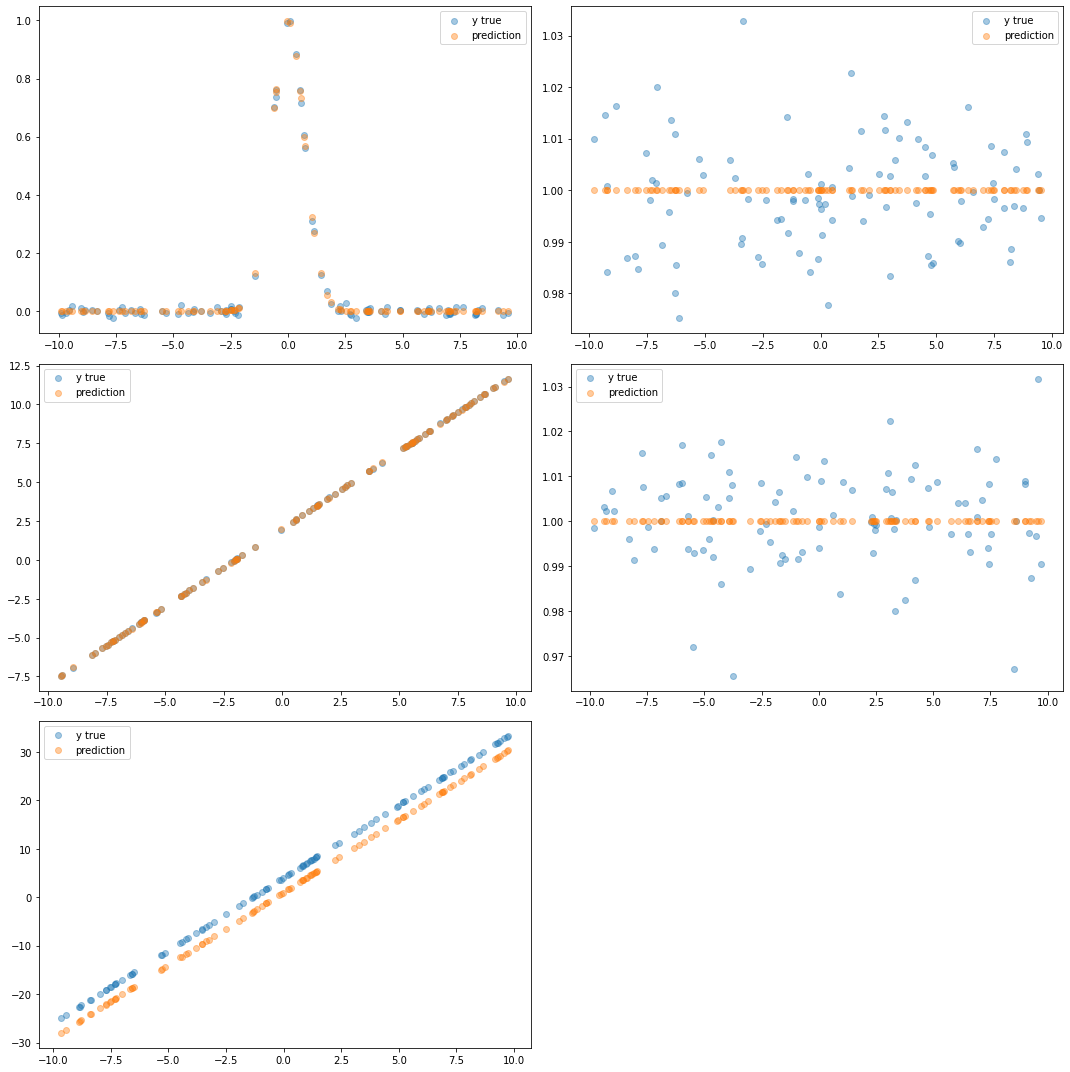

In [ ]:
plt.figure(figsize=(15, 15))

for i, (x, y, tree) in enumerate(zip(X, Y, final_trees)): 
    plt.subplot((len(X) + 1) // 2, 2, i+1)
    plt.scatter(x, y, alpha=0.4, label='y true')
    plt.scatter(x, Model(tree)(x), alpha=0.4, label='prediction') 
    plt.legend()
    
plt.tight_layout()